# Алгоритм 1: метод проекции градиента с граничениями

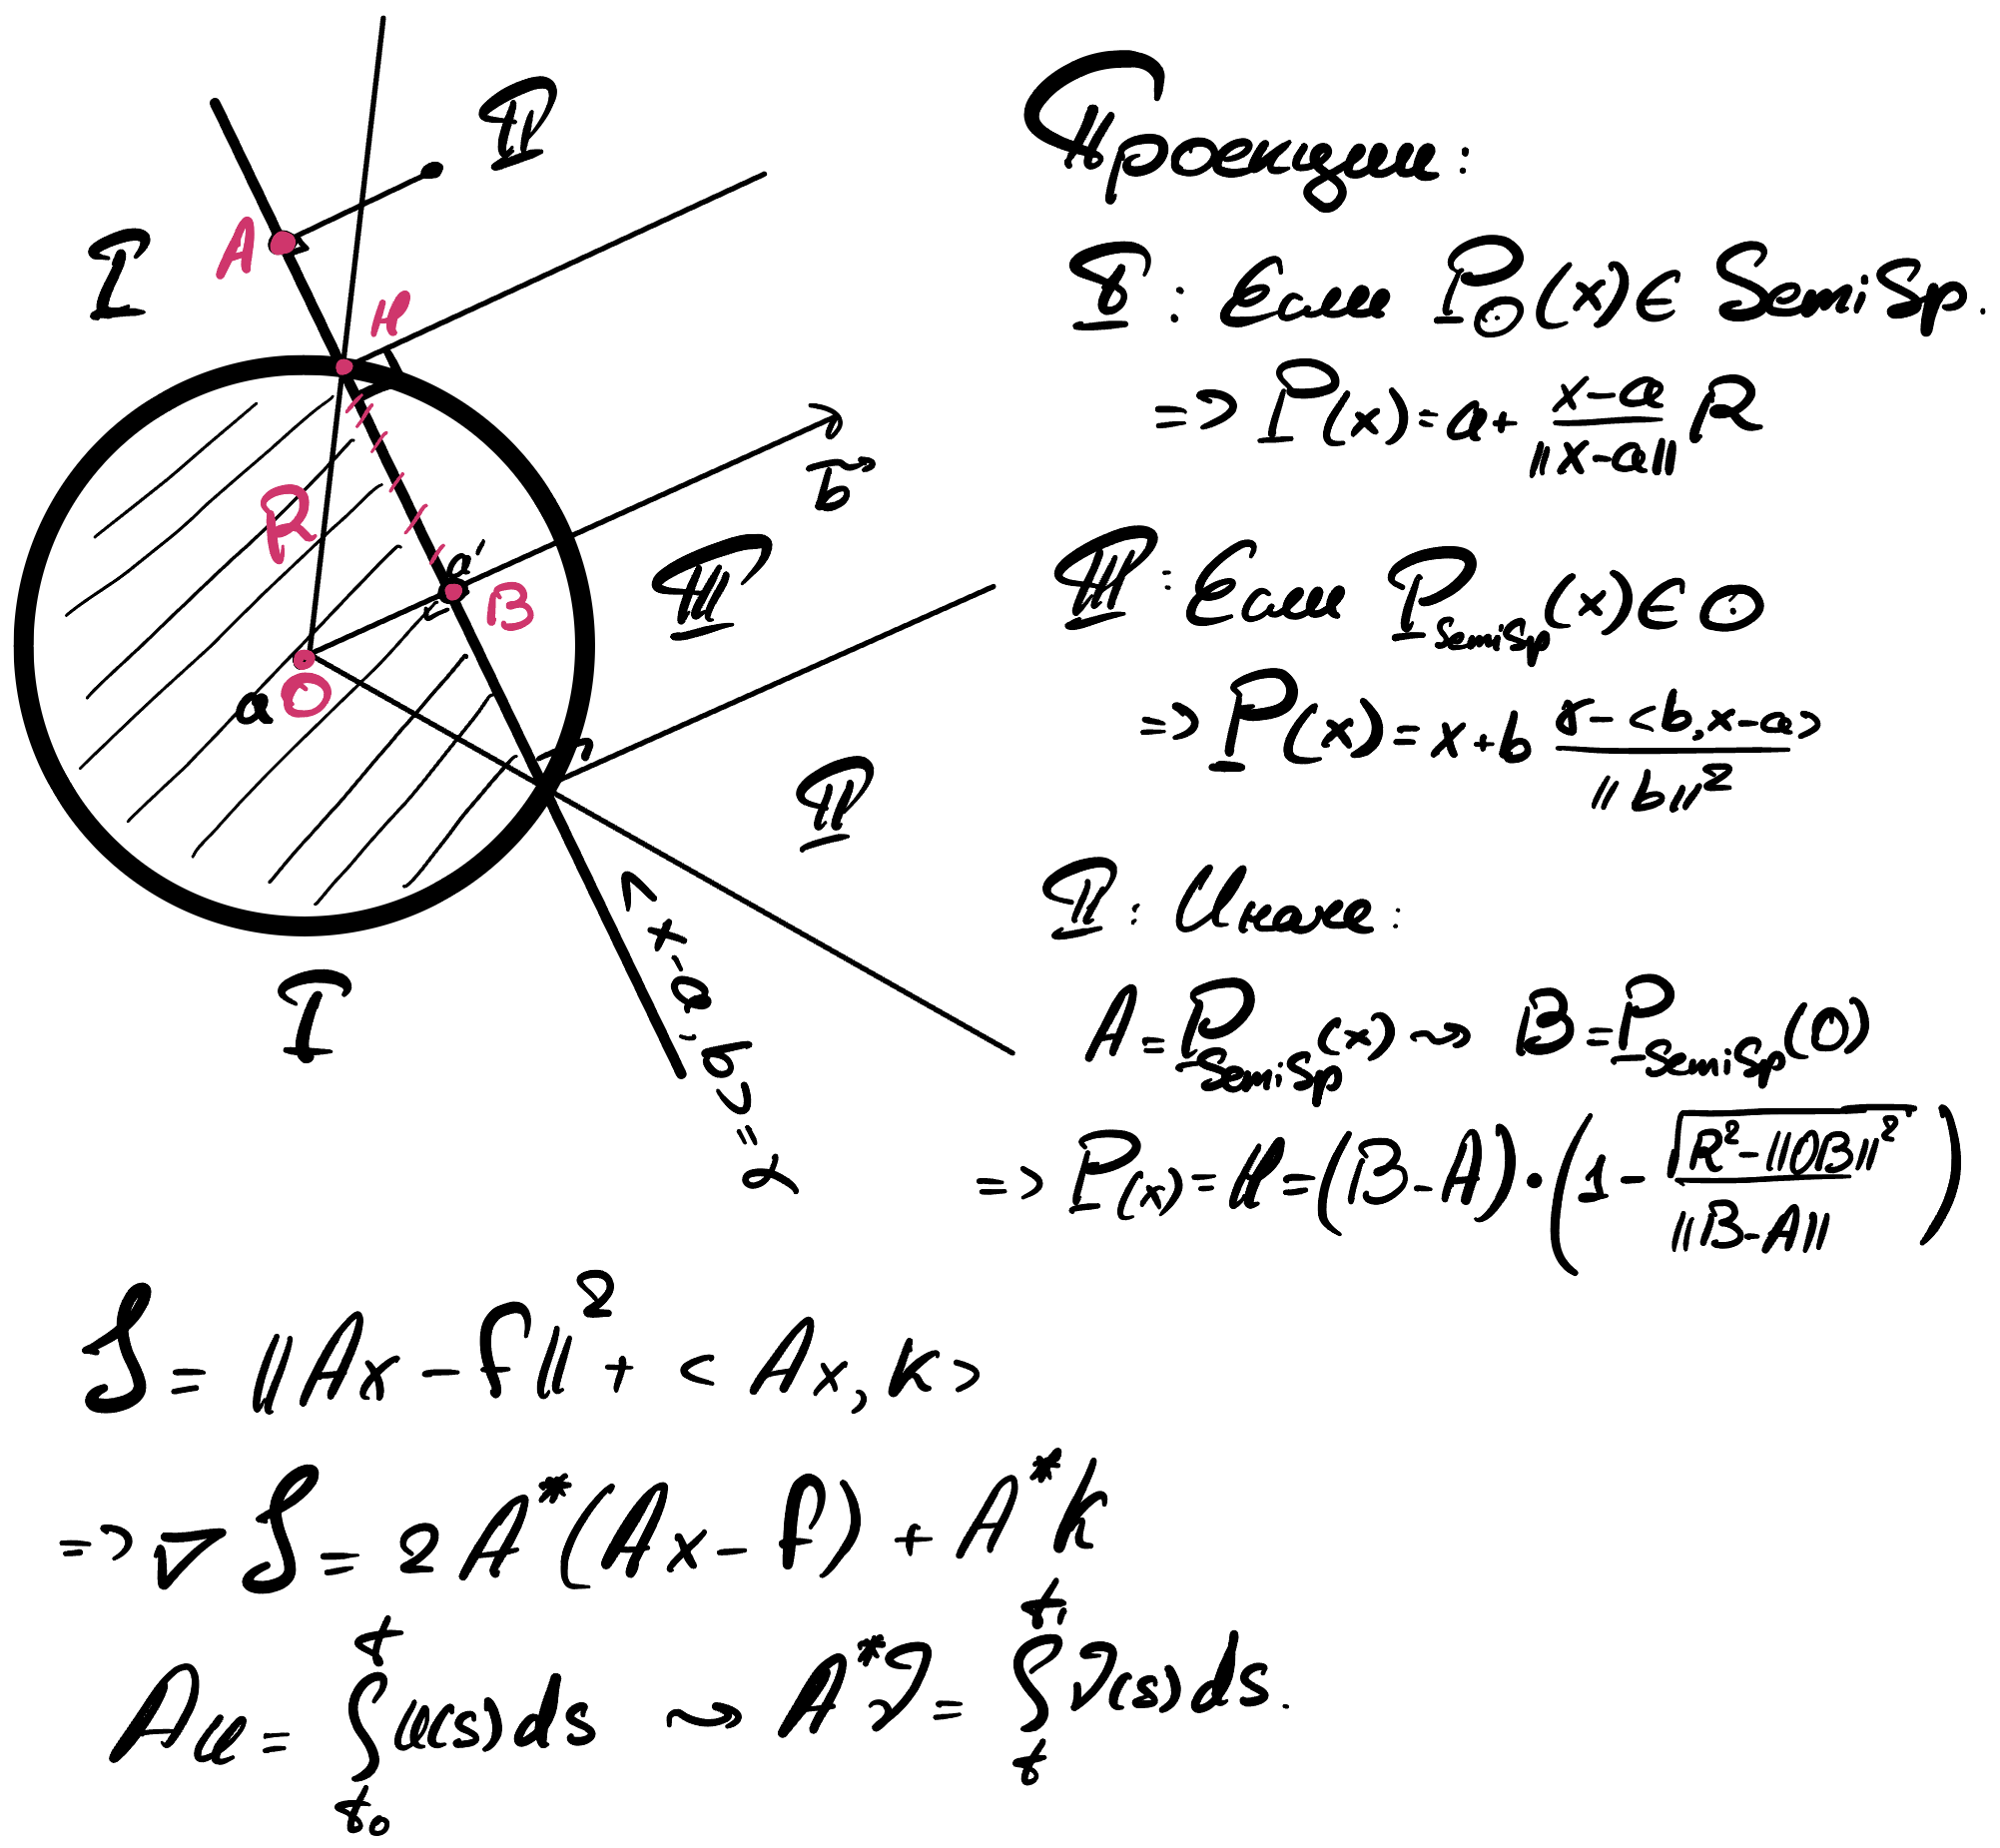

In [1]:
import scipy.integrate
import numpy as np

%load_ext autoreload
%autoreload 2

### Инициализация параметров

In [2]:
lnsp = np.linspace(0, 1, 10_000)

a = np.sin(lnsp)
b = np.cos(lnsp) + np.sin(lnsp) / 2
scipy.integrate.simpson(b, dx=1/len(b))
R = 3
gamma = 2

f = np.exp(lnsp)
g = np.log(lnsp + 3)
k = lnsp ** 2 - 3

### Подготовка оболочки решения

In [3]:
from methods.gradient_projection.functional import FunctionalOracle
from methods.gradient_projection.oracles import ProjectionOracle, GradientProjectionMethod

J = FunctionalOracle(f, g, k)
Oracle = ProjectionOracle(a, R, b, gamma)
Solver = GradientProjectionMethod(Oracle, J, J.grad, x0=np.zeros(10_000), epsilon=None, max_iter=150)

### Решение

In [4]:
print(f'Изначальное значение функционала: {Solver.get_value()}')

Изначальное значение функционала: 31942.085966603794


In [5]:
x = Solver.run()

In [6]:
print(f'Новое оптимальное значение функционала: {Solver.get_value()}')

Новое оптимальное значение функционала: -44033.23274160677


In [7]:
print(f'Принадлежит ли оптимальный x области граничения: {Oracle.check_inside(x)}')

Принадлежит ли оптимальный x области граничения: True


# Алгоритм 2: имплементация вычислительно стабильного быстрого метода Newton-CG

Рассмотрим задачу количественной регресии (count regression). Пусть дана выборка $\{x_i,y_i\}_{i=1}^\ell$, где $x_i\in\mathbb{R}^d$, $y_i\in\mathbb{N}\cup\{0\}$.

Будем считать, что
$$
y\sim p(y\,|\,\lambda)={e^{-\lambda}\over y!}\lambda^{y},
$$
где $\lambda=\exp(w^Tx)$.

Как вы могли догадаться, мы имеем дело с обобщённой линейной моделью. Обучение производится методом максимизации правдоподобия:
$$
p(X\,|\,w)=\prod_{i=1}^\ell p(y_i\,|\,x_i,w)\to\max_w\iff \mathcal{L}(x,y,w)=-\log p(y\,|\,\exp(w^Tx)),\ Q=\sum_{i=1}^\ell\mathcal{L}(x_i,y_i,w)\to\min_w.
$$

Алгоритм предсказания пуассоновской регрессии:
$$
a(x)=\lfloor\exp(w^Tx)\rfloor.
$$

Выведем градиент:
$$
    \nabla_w Q = \nabla_w \left ( \sum_{i=1}^\ell\mathcal{L}(x_i,y_i,w) \right ) \Longrightarrow 
    \nabla_w \mathcal{L}(x_i,y_i,w) =
    \nabla_w \left ( - \log(\frac{\lambda^y}{y!} e^{-w^Tx}) \right ) = 
    - \frac{y!}{\lambda^y} e^{w^Tx} \left ( \frac{y}{y!} \lambda^{y-1} e^{w^Tx} - \frac{\lambda^y}{y!} X e^{w^Tx} \right ) = 
    \left ( 1 - \frac{y}{\lambda} \right ) \lambda X = \left( \lambda - y \right ) X \\

    \nabla_w Q = \sum_{i=1}^\ell \left( \lambda_i - y_i \right ) X_i = \left( \lambda - y \right ) X 
$$

Выведем гессиан:

$$
    d_w (\lambda - y) X^T dw_1 = d_w \lambda X^T dw_1 = {dw_2}^T \lambda X X^T dw_1 = <\lambda X X^T dw_1, dw_2> 
    \Longrightarrow \nabla^2_w Q = \sum_{i=1}^\ell \lambda_i X_i X_i^T = ( \lambda \cdot X ) X^T
$$

In [2]:
from methods.NewtonDescend.oracles import PoisOracle, Newton_CGMethod
import pandas as pd
import numpy as np

### Чтение данных и предобработка

In [3]:
ds = pd.read_csv('dataset.csv')
X = ds.drop(columns='target')
y = ds.target

In [4]:
# cycle encode time features
data = X[['month', 'day']].copy()
data['month_sin'] = np.sin(2 * np.pi * data['month']/31)
data['month_cos'] = np.cos(2 * np.pi * data['month']/31)

data['day_sin'] = np.sin(2 * np.pi * data['day']/12)
data['day_cos'] = np.cos(2 * np.pi * data['day']/12)

# normalize other features
data2 = X.drop(columns=['month', 'day'])
data2 = (data2 - data2.mean()) / data2.std()

# add constant feature
n_samples = ds.shape[0]
X = pd.concat([data2, data[['month_sin', 'month_cos', 'day_sin', 'day_cos']]], axis=1)
X['constant'] = np.ones(n_samples)
X.head()

,lane_0,lane_1,lane_2,lane_3,lane_4,lane_5,lane_6,lane_7,lane_8,lane_9,...,lane_11,lane_12,lane_13,lane_14,lane_15,month_sin,month_cos,day_sin,day_cos,constant
0,-1.200839,-1.221582,-1.198296,-0.880348,-1.079269,-1.131425,-1.228446,-0.930486,-1.294226,-1.352611,...,-0.885145,-1.279551,-1.326210,-1.226873,-1.162284,0.201299,0.979530,0.5,0.866025,1.0
1,-1.203568,-1.221154,-1.200379,-0.854252,-1.072729,-1.138488,-1.217139,-0.927173,-1.263520,-1.311771,...,-0.841856,-1.285154,-1.341468,-1.192567,-1.170318,0.394356,0.918958,0.5,0.866025,1.0
2,-1.203568,-1.222010,-1.208713,-0.856698,-1.062920,-1.135461,-1.227033,-0.934626,-1.286399,-1.333616,...,-0.876487,-1.282353,-1.256462,-1.215233,-1.166301,0.571268,0.820763,0.5,0.866025,1.0
3,-1.206841,-1.214309,-1.216004,-0.886056,-1.070549,-1.146560,-1.239754,-0.936282,-1.325534,-1.390602,...,-0.893802,-1.294493,-1.368350,-1.236062,-1.186386,0.724793,0.688967,0.5,0.866025,1.0
4,-1.207387,-1.222437,-1.216004,-0.863630,-1.079269,-1.146560,-1.239047,-0.931314,-1.329146,-1.393451,...,-0.811554,-1.295427,-1.353092,-1.205432,-1.146217,0.848644,0.528964,0.5,0.866025,1.0


### Определение задачи

In [5]:
X = X.to_numpy()
y = y.to_numpy()

Oracle = PoisOracle(X, y)
solver = Newton_CGMethod(
    w_init = np.random.normal(scale=1e-4, size=X.shape[1]),
    f=Oracle.fun,
    grad=Oracle.grad,
    hess=Oracle.hess,
    alpha=1e-3,
    epsilon=None,
    max_iter=250
)

### Решение

In [6]:
print(f'Начальное приближение решения задачи: {solver.get_value():.4f}')

Начальное приближение решения задачи: 816.1533


In [7]:
x_star = solver.run()

In [9]:
print(f'Достигнутое оптимальное решение: {solver.get_value()}')

Достигнутое оптимальное решение: -6218939.4569855


# Алгоритм 3: симплекс метод для приведенной формы для решения задачи на максимум

$$
\begin{equation*}
    \left\{
      \begin{aligned}
        & \left \langle c, x \right \rangle \longrightarrow \max \\
        & Ax \leq b 
      \end{aligned}
    \right.
\end{equation*}
$$

In [2]:
from methods.simplex_method.oracle import SimplexMethod
import numpy as np

### Задание параметров и оболочки решения

In [3]:
c = np.array([1, 1, -1, 0, 1])
A = np.array([
    [1, 0, 0, 1, -1],
    [1, 1, 0, 2,  0],
    [0, 0, 1, 1,  0],
    [-1, 0, 0, -1, 1],
    [-1, -1, 0, -2, 0],
    [0, 0, -1, -1,  0],
])
b = np.array([1, 3, 1, -1, -3, -1])

solver = SimplexMethod(c, A, b, 10)

### Решение

In [4]:
print(f'Изначальное решение со всеми нулями: {solver.get_value()}')

Изначальное решение со всеми нулями: 0.0


In [5]:
optim_cords, optim_value = solver.solve()

/Users/artemon/Library/Mobile Documents/com~apple~CloudDocs/Programming/python_projects/MethodsOfOptimization/methods/simplex_method/oracle.py:31: RuntimeWarning: divide by zero encountered in divide
  convergence_speed = matrix[:-1, -1] / matrix[:-1, leading_column]
/Users/artemon/Library/Mobile Documents/com~apple~CloudDocs/Programming/python_projects/MethodsOfOptimization/methods/simplex_method/oracle.py:31: RuntimeWarning: invalid value encountered in divide
  convergence_speed = matrix[:-1, -1] / matrix[:-1, leading_column]
/Users/artemon/Library/Mobile Documents/com~apple~CloudDocs/Programming/python_projects/MethodsOfOptimization/methods/simplex_method/oracle.py:35: RuntimeWarning: divide by zero encountered in divide
  save_leading_row = (matrix[leading_row, :] / matrix[leading_row, leading_column]).copy()
/Users/artemon/Library/Mobile Documents/com~apple~CloudDocs/Programming/python_projects/MethodsOfOptimization/methods/simplex_method/oracle.py:35: RuntimeWarning: invalid val

In [6]:
optim_cords

array([nan,  0.,  0.,  0., nan])

In [7]:
print(f'Оптимальное решение: {optim_value}')

Оптимальное решение: nan


# Алгоритм 4: Применение двустороннего ADMM для задачи восстановления изображения

Перед нами стоит задача условной оптимизации, где условия задаются на составных элементах решения. Для Решения задачи воспользуемся алгоритмом ADMM, сведя задачу к специальному виду:

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
        & \min_{X}\|X \|_* \\
        & X_{i,j} = Y_{i,j}, \quad (i,j) \in E
      \end{aligned}
    \right.
  \end{equation*}
  \Longrightarrow
  \begin{equation*}
    \left\{
      \begin{aligned}
        & \min_{X, Y} f(X) + g(Y) \\
        & AX + BY = C, \, \, где \, A, \,  B \, линейные \, операторы
      \end{aligned}
    \right.
  \end{equation*}
$$

Тогда получим следующую запись ADMM при заданные обозначениях:
* Пусть P будет оператором проектирования Y на подпространство матриц с базисом \{i, j\} = 1
* $Z \in \mathbb{R}^{m \times n}$ матрица изначальных данных о фото (все остальные значения равны 0)


$$
  \Longrightarrow
  \begin{equation*}
    \left\{
      \begin{aligned}
        & \min_{X, Y} \|X \|_* + \mathbb{I}_{\left \{ Y = Z, \, (i,j)\in E\right \}}^\infty \\
        & X = Y
      \end{aligned}
    \right.
  \end{equation*}
  \Longrightarrow \text{Решение ADMM:} \,\,\,
  \begin{equation*}
    \left\{
      \begin{aligned}
        & X^{k + 1} = \argmin_X \left\{\|X \|_* + \frac{1}{2r} \|\lambda^k + r \left(X - Y^k \right) \|^2_2 \right\} \\
        & Y^{k + 1} = \argmin_Y \left\{\mathbb{I}_{\left \{ Y = Z, \, (i,j)\in E\right \}}^\infty + \frac{1}{2r} \|\lambda^k + r \left(X^{k + 1} - Y \right) \|^2_2 \right\} \\
        & \lambda^{k + 1} = \lambda^k + r \left(X^{k + 1} - Y^{k + 1} \right)
      \end{aligned}
    \right.
  \end{equation*}
$$

---
Найдем теперь аналитическую запись для $X^{k + 1}$:

$$
  X^{k + 1} = \argmin_X \left\{\|X \|_* + \frac{1}{2r} \|\lambda^k + r \left(X - Y^k \right) \|^2_2 \right\} =
              \argmin_X \left\{\|X \|_* + \frac{r}{2} \|X - \left(Y^k - \frac{\lambda^k}{r}\right) \|^2_2 \right\} =
              {prox}_{\| \cdot \|, \frac{r}{2}}\left(Y^k - \frac{\lambda^k}{r} \right) = \\ \\
              = {prox}_{g(singular), \frac{r}{2}}\left(Y^k - \frac{\lambda^k}{r}\right) =
              \left \{ \left( Y^k - \frac{\lambda^k}{r} \right) = T \right \} =
              {prox}_{g(singular), \frac{r}{2}}\left(T\right) = \left\{SVD \rightarrow T \right\} =
              U_T \cdot diag\left(prox_{g, \frac{r}{2}}\left( \Sigma_T \right) \right) \cdot V^*_T
$$

Решим задачу для $prox_{g, \frac{r}{2}} \left( \Sigma_T \right) = prox_{g, \frac{r}{2}} \left(\sigma_1 \, ... \, \sigma_\gamma \right)$:

$$
  prox_{g, \frac{r}{2}} \left(\sigma_1 \, ... \, \sigma_\gamma \right) =
  \argmin_{(\hat{\sigma_1} \, ... \, \hat{\sigma_\gamma})} \left \{\sum \hat{\sigma_i} + \frac{r}{2} \sum \left(\hat{\sigma_i} - \sigma_i \right)^2 \right \}
  \longrightarrow
  \hat{\sigma_i} = \frac{r\sigma_i - 1}{r}; \, \, \, \left(\hat{\sigma}_1 \, ... \, \hat{\sigma}_\gamma \right) = \left(1 - \frac{1}{r} \right)\left(\sigma_1 \, ... \, \sigma_\gamma \right)
$$

Сдедовательно:

$ X^{k + 1} = U_T \cdot diag\left(\left(1 - \frac{1}{r} \right) \left(\sigma_1 \, ... \, \sigma_\gamma \right) \right) \cdot V^*_T, \, \, \, T = \left( Y^k - \frac{\lambda^k}{r} \right)$

---
Найдем теперь аналитическую запись для $Y^{k + 1}$:
$$
  Y^{k + 1} = \argmin_Y \left\{\mathbb{I}_{\left \{ Y = Z, \, (i,j)\in E\right \}}^\infty + \frac{1}{2r} \|\lambda^k + r \left(X^{k + 1} - Y \right) \|^2_2 \right\}
  \Longrightarrow
  \begin{equation*}
    \left\{
      \begin{aligned}
        & (i, j) \notin E \Rightarrow Y_{i, j} = X^{k + 1}_{i, j} + \frac{\lambda^k_{i, j}}{r} + 0 \\
        & (i, j) \in E    \Rightarrow Y_{i, j} = Z_{i, j} \\
      \end{aligned}
    \right.
  \end{equation*}
$$

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']

from methods.ADMM.tools import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.237962369334683e-15..1.0000000000000022].


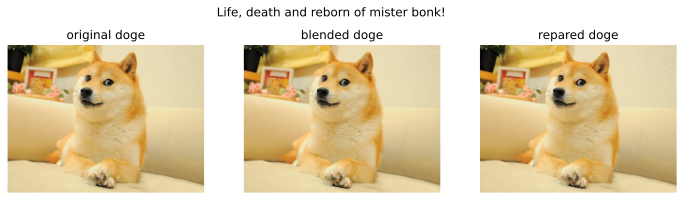

In [11]:
img = cv2.imread('doge.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
img = cv2.resize(img, (0,0), fx=0.3, fy=0.3)

r_mask, g_mask, b_mask = make_mask(*img.shape[:2], 0.0), make_mask(*img.shape[:2], 0.0), make_mask(*img.shape[:2], 0.0)


broken_image = np.zeros_like(img)
broken_image[*r_mask, 0] = img[*r_mask, 0]
broken_image[*g_mask, 1] = img[*g_mask, 1]
broken_image[*b_mask, 2] = img[*b_mask, 2]

cured = cure_image(broken_image, [r_mask, g_mask, b_mask], 0.0, 5, 2)

fig, axis = plt.subplots(1, 3)
fig.suptitle("Life, death and reborn of mister bonk!")
fig.set_figwidth(12)
fig.set_figheight(3.2)

axis[0].set_title('original doge')
axis[0].imshow(img)
axis[0].grid(False)
axis[0].axis(False)

axis[1].set_title('blended doge')
axis[1].imshow(broken_image)
axis[1].grid(False)
axis[1].axis(False)

axis[2].set_title('repared doge')
axis[2].imshow(cured)
axis[2].grid(False)
axis[2].axis(False)

plt.show()